In [1]:
#Portfolio Optimization Using Monte Carlo Simulation
#https://www.quantinsti.com/blog/portfolio-optimization-maximum-return-risk-ratio-python/
#
#Code
#------------------------------------------------------------------------------------------

#Import relevant libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



#Fetch data from yahoo and save under DataFrame named 'data'
stock = ['BAC', 'GS', 'JPM', 'MS']
start_date='2024-01-01'
end_date ='2024-12-31'
data = yf.download(stock, start=start_date, end=end_date,auto_adjust=False)["Adj Close"]

# Flatten the multi-index columns
data.columns = ['_'.join(col).strip() for col in data.columns.values]
data.head()

[*********************100%***********************]  4 of 4 completed


,B_A_C,G_S,J_P_M,M_S
Date,,,,
2024-01-02,32.851429,377.245605,166.179565,89.284668
2024-01-03,32.492874,370.920959,165.455276,87.392487
2024-01-04,32.754520,372.047943,166.553253,87.620689
2024-01-05,33.365032,375.438599,167.388885,88.657104
2024-01-08,33.103386,377.789673,167.145996,88.913834


In [2]:
#Compute stock returns and print the returns in percentage format
stock_ret = data.pct_change()
print (stock_ret.round(4)*100)


            B_A_C   G_S  J_P_M   M_S
Date                                
2024-01-02    NaN   NaN    NaN   NaN
2024-01-03  -1.09 -1.68  -0.44 -2.12
2024-01-04   0.81  0.30   0.66  0.26
2024-01-05   1.86  0.91   0.50  1.18
2024-01-08  -0.78  0.63  -0.15  0.29
...           ...   ...    ...   ...
2024-12-23  -0.63  0.83   0.33  0.82
2024-12-24   1.12  2.10   1.64  2.10
2024-12-26   0.38 -0.27   0.34  0.76
2024-12-27  -0.47 -0.87  -0.81 -0.99
2024-12-30  -0.97 -0.46  -0.77 -0.80

[251 rows x 4 columns]


In [3]:
#Calculate mean returns and covariances of all four the stocks

daily_returns = stock_ret.mean()
mean_returns = stock_ret.mean()*252
cov_matrix = stock_ret.cov()*252
print (mean_returns)
print (cov_matrix)


B_A_C    0.311970
G_S      0.450367
J_P_M    0.383907
M_S      0.364621
dtype: float64
          B_A_C       G_S     J_P_M       M_S
B_A_C  0.052034  0.043756  0.040258  0.040840
G_S    0.043756  0.066842  0.047369  0.053826
J_P_M  0.040258  0.047369  0.055535  0.040262
M_S    0.040840  0.053826  0.040262  0.068850


In [4]:
#Set the number of iterations to 10000 and define an array to hold the simulation results; initially set to all zeros
num_iterations = 10000
simulation_res = np.zeros((4+len(stock)-1,num_iterations))


In [5]:
for i in range(num_iterations):
#Select random weights and normalize to set the sum to 1
        weights = np.array(np.random.random(4))
        weights /= np.sum(weights)

#Calculate the return and standard deviation for every step
        portfolio_return = np.sum(mean_returns * weights)
        portfolio_std_dev = np.sqrt(np.dot(weights.T,np.dot(cov_matrix, weights)))
  
#Store all the results in a defined array
        simulation_res[0,i] = portfolio_return
        simulation_res[1,i] = portfolio_std_dev
    
#Calculate Sharpe ratio and store it in the array
        simulation_res[2,i] = simulation_res[0,i] / simulation_res[1,i]
    
#Save the weights in the array
        for j in range(len(weights)):
                simulation_res[j+3,i] = weights[j]

In [6]:
# We then save the output in a ‘pandas data frame’ for easy analysis and plotting of data.
sim_frame = pd.DataFrame(simulation_res.T,columns=['ret','stdev','sharpe',stock[0],stock[1],stock[2],stock[3]])
print (sim_frame.head (5))
print (sim_frame.tail (5))

        ret     stdev    sharpe       BAC        GS       JPM        MS
0  0.372583  0.217626  1.712036  0.306097  0.213561  0.299019  0.181323
1  0.363463  0.216364  1.679873  0.394337  0.130685  0.435499  0.039480
2  0.389084  0.222811  1.746252  0.133718  0.290982  0.339756  0.235544
3  0.387731  0.227346  1.705464  0.193391  0.360197  0.124769  0.321643
4  0.403024  0.230934  1.745187  0.147800  0.508287  0.134870  0.209043
           ret     stdev    sharpe       BAC        GS       JPM        MS
9995  0.393074  0.226539  1.735132  0.086871  0.322538  0.278485  0.312106
9996  0.380222  0.220915  1.721121  0.251156  0.283732  0.233118  0.231994
9997  0.378073  0.225809  1.674303  0.274834  0.308734  0.075159  0.341274
9998  0.361877  0.221326  1.635042  0.315757  0.127436  0.153136  0.403672
9999  0.386932  0.231995  1.667842  0.193662  0.371691  0.032976  0.401671


In [7]:
#Spot the position of the portfolio with highest Sharpe Ratio
max_sharpe = sim_frame.iloc[sim_frame['sharpe'].idxmax()]

#Spot the position of the portfolio with minimum Standard Deviation
min_std = sim_frame.iloc[sim_frame['stdev'].idxmin()]

# Define target standard deviation and tolerance
target_sd = 0.23
tolerance = 0.005  # allows 0.225 to 0.235 SD

# Filter portfolios within the tolerance band of the target SD
near_target_sd = sim_frame[(sim_frame['stdev'] >= target_sd - tolerance) & 
                           (sim_frame['stdev'] <= target_sd + tolerance)]

# Spot the one with highest return among the filtered ones
if not near_target_sd.empty:
    best_at_target_sd = near_target_sd.sort_values('ret', ascending=False).iloc[0]
else:
    print("No portfolio found near the target standard deviation.")

print("The portfolio for max Sharpe Ratio:\n", max_sharpe)
print("The portfolio for min risk:\n", min_std)
print("The portfolio with standard deviation closest to 23%:\n", best_at_target_sd)

#------------------------------------------------------------------------------------------

The portfolio for max Sharpe Ratio:
 ret       0.422893
stdev     0.235598
sharpe    1.794974
BAC       0.007436
GS        0.600565
JPM       0.371630
MS        0.020369
Name: 9591, dtype: float64
The portfolio for min risk:
 ret       0.347404
stdev     0.213900
sharpe    1.624142
BAC       0.458589
GS        0.000216
JPM       0.358250
MS        0.182945
Name: 1505, dtype: float64
The portfolio with standard deviation closest to 23%:
 ret       0.419614
stdev     0.234454
sharpe    1.789751
BAC       0.045694
GS        0.601202
JPM       0.303228
MS        0.049876
Name: 7443, dtype: float64


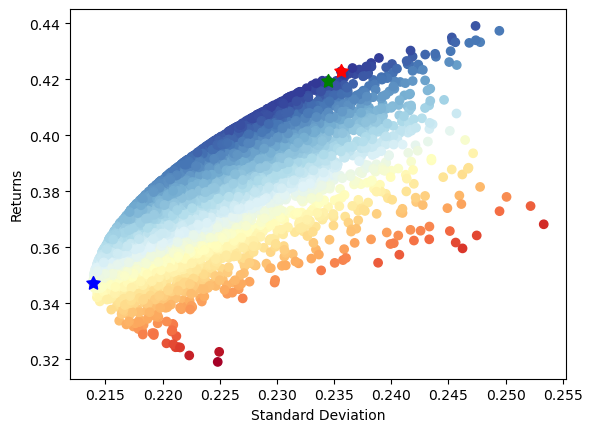

In [20]:
#Create a scatter plot coloured by various Sharpe Ratios with standard deviation on the x-axis and returns on the y-axis
plt.scatter(sim_frame.stdev,sim_frame.ret,c=sim_frame.sharpe,cmap='RdYlBu')
plt.xlabel('Standard Deviation')
plt.ylabel('Returns')

#Plot a red star to highlight position of the portfolio with highest Sharpe Ratio
plt.scatter(max_sharpe.iloc[1],max_sharpe.iloc[0],marker=(5,1,0),color='r',s=100)

#Plot a blue star to highlight position of the portfolio with minimum Variance
plt.scatter(min_std.iloc[1],min_std.iloc[0],marker=(5,1,0),color='b',s=100)

#Plot a green star to highlight position of the portfolio closest to our, maximum retrun portfolio at given target risk
plt.scatter(best_at_target_sd['stdev'], best_at_target_sd['ret'], marker=(5,1,0), color='g', s=100, label='Target SD (23%)')

plt.show()
